# 11-1. 들어가며

이번 시간에는 OCR을 직접 만들어보는 시간을 갖도록 하겠습니다. OCR을 처음부터 끝까지 만들기에는 시간이 많이 소요되므로 Detection은 keras-ocr을 활용하고, Recognition은 직접 만들어 학습해보도록 하겠습니다.

### 학습 목표
---
1. Text Recognition 모델을 직접 구현할 수 있습니다.
2. Text Recognition 모델 학습을 수행할 수 있습니다.
3. Text Detection 모델과 연결하여 전체 OCR 시스템을 구현할 수 있습니다.

### 학습 내용
---
2. Overall sturcture of OCR
    - Text Detection + Text Recognition 파트로 구성된 OCR 모델의 전반적인 구조를 배워보아요.
3. Dataset for OCR
    - Recognition 모델의 정량적인 평가를 위해 MJSynth와 SynthText 데이터셋을 활용해보아요.
4. Recognition model
    - CRNN 모델 구조에 대한 이해와 필요한 라이브러리들을 import 해봅시다.
5. Input Image
    - 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해 봅시다.
6. Encode
    - 각각의 문자를 인코딩해주는 LabelConverter 클래스를 작성해 봅시다.
7. Build CRNN model
    - K.ctc_batch_cost()를 활용하여 CRNN 모델을 직접 구현해보아요.
8. Train & Inference
    - 모델을 직접 학습시켜보고, 모델의 성능을 눈으로 직접 확인해 봅시다.  
    
- 프로젝트 : End-to-End OCR

# 11-2. Overall sturcture of OCR

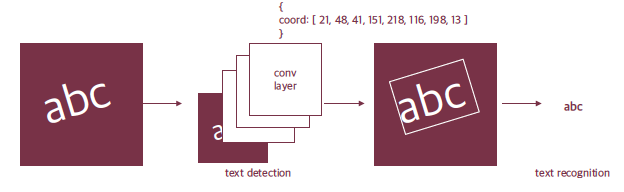
https://brunch.co.kr/@kakao-it/318  

우리가 만들고자 하는 OCR은 이미지 속에서 영문을 Bounding box로 찾아내고 그 Bounding box 내에 어떤 Text가 포함되는지 알 수 있는 시스템입니다. 이미지 속에서 문자 영역을 찾아내는 것인 Text Detection은 이전에 봤던 방법 중 Segmentation 기반의 CRAFT를 활용한 keras-ocr을 활용할 예정입니다. Recognition 모델은 keras-ocr을 사용하지 않고 직접 만들어보도록 하겠습니다.  

- keras-ocr 공식 github https://github.com/faustomorales/keras-ocr
- CRAFT: Character Region Awareness for Text detection https://arxiv.org/pdf/1904.01941
    - CRAFT Pytorch 공식 implementation https://github.com/clovaai/CRAFT-pytorch
    - CRAFT Keras 버전 github https://github.com/notAI-tech/keras-craft

#### Q. keras-ocr에서도 recognition을 지원하는데요 이 모델은 어떤 구조를 썼을까요?

CRNN을 기본으로 설계된 CTC (Connectionist Temporal Classification) 

CNN과 RNN의 아이디어를 결합하여 Text Recognition의 초기 모델의 뼈대를 완성했던 CRNN 모델도 2015년에 나온 것입니다. 그 이후로도 다양한 모델들이 새로운 기법을 제시하며 조금씩 성능 향상을 이루어 왔습니다. 2019년에 발표된 Naver Clova의 아래 논문에서 당시까지의 모델의 발전사를 잘 살펴볼 수 있습니다.

- What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis  
https://arxiv.org/pdf/1904.01906

#### Q. keras-ocr의 CRNN 기반 Recognition 모델과 위 논문에 소개된 Recognition에서 가장 높은 성능을 얻은 (저자들의) 모델은 어떤 점이 다를까요?

첫 번째로 입력 이미지 변환 단계에서는 모델의 앞에서 글자를 Thin plate spline Transformation을 해주는 TPS 모듈이 붙고, 마지막 Text 출력 단계에서는 Bidirectional LSTM 뒤로 Attention decoder가 붙습니다.

# 1-3. Dataset for OCR

OCR은 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야 하는 번거로움이 있습니다. 따라서 OCR 데이터를 대량으로 만들려면 큰 비용이 듭니다. 데이터 문제를 해결하기 위한 방법 중 하나로는 컴퓨터로 대량 문자 이미지 데이터를 만들어내는 방법입니다. 직접 문자 데이터를 생성하게 되면, 원하는 언어를 원하는 폰트와 원하는 배치 및 크기로 문자 이미지를 대량으로 만들어낼 수 있다는 장점이 있습니다.

이전 스텝에서 소개했던 What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis https://arxiv.org/pdf/1904.01906과 같은 논문들에서는 Recognition model의 정량적인 평가를 위해서 MJSynth와 SynthText라는 데이터셋을 활용합니다. Recognition model을 제안하는 다양한 논문들에서도 성능 비교를 위해 두 데이터를 활용한다는 것을 기억해두시면 좋을 것 같습니다.

- MJSynth (official website) https://www.robots.ox.ac.uk/~vgg/data/text/
- SynthText https://www.robots.ox.ac.uk/~vgg/data/scenetext/

앞으로 만들어볼 Recognition model 학습을 위해 MJSynth를 사용해보도록 하겠습니다. 아래의 링크는 Naver Clova의 논문 저자들이 Dropbox를 통해 제공하는 데이터셋입니다.

아래 링크의 training 폴더에서 data_lmdb_release.zip 내 있는 MJ 데이터만 활용할 예정입니다.

Dropbox-data_lmdb_release  
https://www.dropbox.com/scl/fo/zf04eicju8vbo4s6wobpq/ALAXXq2iwR6wKJyaybRmHiI?rlkey=2rywtkyuz67b20hk58zkfhh2r&e=1&dl=0  

클라우드를 사용중이라면 다운로드는 받지 않으셔도 됩니다.

#### Q. MJSynth 데이터셋은 어떻게 구성되어 있을지 이야기해볼까요!

MJSynth 데이터셋은 9만장의 이미지, 900만 개의 단어가 포함되어 있는 합성 데이터셋으로,  
90개 이상의 글꼴과 9개의 서로 다른 형태의 문장 구조를 사용하여 합성되었습니다.  
이렇게 합성된 이미지에서 텍스트 영역과 바운딩 박스 정보가 추출되어 데이터셋에 포함됩니다.  


### 데이터 준비
---
우측 하단의 Cloud shell을 클릭해서 열어주세요. 아래 명령어를 통해 데이터를 준비합니다.
```
$ mkdir -p ~/aiffel/ocr 
$ ln -s ~/data ~/aiffel/ocr/data
```

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


# 11-4. Recognition model

Text recognition 모델을 직접 만들어보도록 하겠습니다. Recognition 모델은 2015년에 발표된 아래 논문에서 처음 소개된 CRNN 구조를 활용해서 만들어보도록 합시다.

- An End-to-End Trainable Neural Network for Image-based SequenceRecognition and Its Application to Scene Text Recognition  https://arxiv.org/pdf/1507.05717  

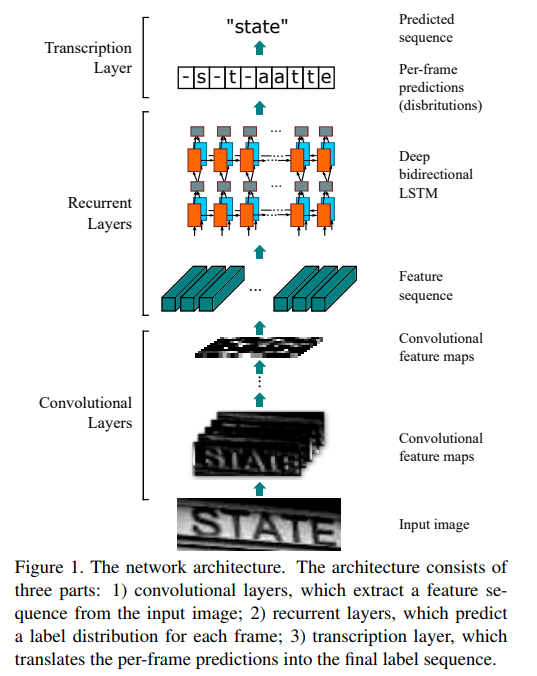  
https://arxiv.org/pdf/1507.05717.pdf  

CRNN의 구조는 위 그림에서 아래부터 올라가는 순서로 보시면 됩니다. 입력이미지를 Convolution Layer를 통해 Feature를 추출하여 추출된 Feature를 얻어냅니다. Recurrent Layer는 추출된 Feature의 전체적인 Context를 파악하고 다양한 output의 크기에 대응이 가능합니다. 끝으로 Transcription layer(Fully connected layer)는 step마다 어떤 character의 확률이 높은지 예측합니다. 아래의 표를 통해 정확한 구조를 확인해주세요.

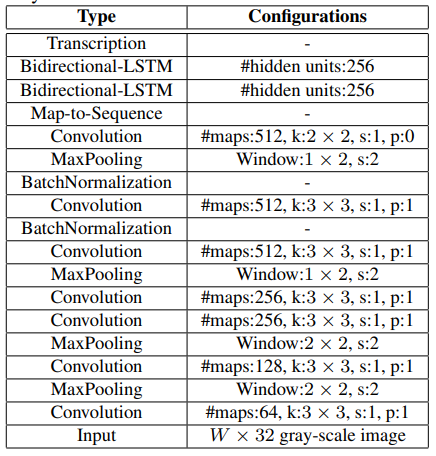
https://arxiv.org/pdf/1507.05717.pdf  


#### Q. CRNN 구조에서 Map-to-Sequence 가 하는 역할은 무엇일까요?  

Convolutional Neural Network(CNN)으로부터 출력된 2D 특징 맵을 1D 시퀀스 형태로 변환  

CRNN의 Map-to-Sequence는 입력 이미지를 RNN 모델에 적용하기 전에, 이미지의 특징 맵을 시퀀스 데이터로 변환하는 방법입니다.

기존의 CNN 모델은 이미지를 입력받아 컨볼루션 레이어와 풀링 레이어 등을 통해 다양한 크기의 특징 맵(feature map)을 추출합니다. 이러한 특징 맵은 각각이 이미지의 일부분에 대한 정보를 담고 있으며, 이들을 RNN에 직접 입력하면 연산 비용이 매우 높아지는 문제가 있습니다.

이를 해결하기 위해, CRNN에서는 특징 맵을 시퀀스 데이터로 변환하여 RNN에 입력합니다. 이때, 특징 맵의 각 행을 시간 축으로 간주하여 시퀀스 데이터로 변환하는 방법이 많이 사용됩니다. 이렇게 변환된 시퀀스 데이터는 RNN의 입력으로 사용되어, 이미지 내에 있는 패턴이나 텍스트 등의 시퀀스 정보를 추출하는 데 사용됩니다.

몇 개의 Class가 필요한지 확인하기 위해 다음 셀을 실행한 후 퀴즈를 풀어보세요.

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


#### Q. 영문 대문자와 숫자를 인식하기 위해서는 몇가지의 Class가 필요할까요?
총 36가지가 필요합니다. 문자가 없는 경우를 위해서 공백을 추가할 경우 class의 수는 37개가 됩니다.

먼저 lmdb를 이용할 예정입니다. LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자입니다. 오늘 우리가 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있습니다.

클라우드에는 이미 설치되어 있으므로 아래의 명령어는 참고로 알아두세요.
```bash
$ pip install lmdb
```

필요한 라이브러리들을 import합니다. 다운로드한 MJ 데이터셋의 위치도 확인해 주세요!

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 11-5. Recognition model (2) Input Image

데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해 봅시다. 아래의 코드를 실행해 lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지를 확인해 보도록 합시다.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


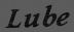

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


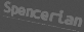

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


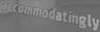

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


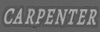

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

어떤가요? 대부분의 이미지의 height는 31, 최대 32까지로 되어 있고, width는 문자열 길이에 따라 다양한 것으로 보입니다.

#### Q. 출력해 본 이미지들이 가로, 세로 길이가 모두 조금씩 다른데요. input data의 사이즈가 이렇게 다 달라도 괜찮을까요?

학습을 위해서는 모델에 동일한 shape으로 input이 들어가야겠죠?!
따라서 바로 밑에서 _get_img_label( ) 이라는 사용자함수를 통해 데이터셋을 조금 다듬어 볼 것입니다🙌
(걱정 노노!😁)


이제부터 lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현하려고 합니다. dataset_path는 읽어들일 데이터셋의 경로입니다. label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 합니다. 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있습니다.

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


위의 분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영되었습니다. 그리고 model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 _get_img_label() 를 통해 가져온 데이터셋을 리턴하게 될 것입니다. _get_img_label() 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있습니다.

# 11-6. Recognition model (3) Encode

이전 스텝에서 살펴본 바에 의하면, Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있었습니다. 그러나 이것은 모델을 학습하기 위해서 적절한 형태가 아닙니다. 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다. 이를 해줄 수 있는 LabelConverter 클래스를 작성해 봅시다.

- __init__()에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2가 됩니다.
- 공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정합니다.
- decode()는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.

>입력받은 text를 모델이 학습할 수 있는 label로 만드는 encode() 메소드를 구현해 주세요!
단, 같은 글자가 연속으로 이어지는 경우에는 이어지는 그 사이에 공백 문자의 label을 포함해야 합니다!

OCR 모델 학습데이터에 왜 공백 문자가 포함되어야 하는지는 다음 스텝에서 설명할 예정입니다.

(다음 스텝에서 자세한 설명이 나오겠지만..)
####  Q. OCR 모델 학습데이터에 왜 공백문자('-', label=0)가 포함이 되어야 하는걸까요? 정답을 알기 전에 각자 한 번씩 생각해볼까요!
CTC는 동일한 문자가 연속해서 나오는 경우를 처리하기 위해, 두 문자 사이에 공백 문자를 삽입  

RCNN 모델은 우리가 지정해 준 크기로 output을 내보낼텐데, 만약 최종 출력 길이를 8로 설정하였고 label이 APPLE인 글자의 경우, AAPPPPLE 이런 형태의 출력을 바탕으로 추론을 해야합니다.
이 때, APLE로 추론을 해야 할 지, APPLE로 추론을 해야 할 지 구분이 불가능하겠죠?

In [11]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        # [[YOUR CODE]]
        for i, char in enumerate(text):
            if i>0 and char==text[i-1]:
                encoded_label.append(0) # 같은 문자 사이에 공백 문자 label 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

아래에서 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해보도록 해보세요!

In [12]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있습니다.

# 11-7. Recognition model (4) Build CRNN model

이제 입력과 출력을 준비했으니 모델을 만들어볼 차례입니다. Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들어두었습니다.

In [13]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


여기서 잠시 Keras의 K.ctc_batch_cost() 함수에 대해 짚고 넘어갑시다. 비록 우리가 이 함수 내부를 직접 구현하진 않겠지만 CTC Loss 함수를 구현하기 위해 우리가 이 함수에 인자로 어떤 값을 넘겨야 하는지는 명확하게 파악해야 합니다.

- Tensorflow Tutorial - ctc_batch_cost  
https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost

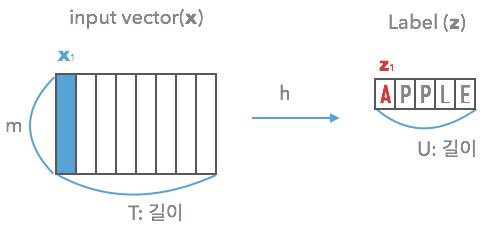  

우리는 CTC Loss를 활용해야 하는 모델이 위 그림과 같은 상황을 다루기 위한 것임을 알고 있습니다. 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 그래서 라벨은 APPLE이지만 모델이 출력한 결과는 AAAPPPPLLLLEE 처럼 나올 수 있습니다. 이런 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 동일하게 적용됩니다.

> 만약 모델이 AAAPPPPLLLLEE을 출력했다고 합시다. 이때 추론 결과는 APLE일지 APPLE일지 구분이 가능할까요? 이 경우에는 APLE로 결론을 내리게 될 것입니다.  
그러므로 추론 결과가 APPLE이 되게 하려면 이미지의 라벨은 AP-PLE로 보정해 주어야 합니다. 그래서 모델이 AAAPP-PPLLLEE로 출력을 한다면 추론 결과는 APPLE이 되는 것입니다. 이런 이유로 이전 스텝에서 LabelConverter.encode() 메소드에 공백문자 처리로직을 포함했던 것입니다.

위 텐서플로우 튜토리얼에 따르면, K.ctc_batch_cost(y_true, y_pred, input_length, label_length)에는 4가지 인자가 존재합니다. 각각의 인자의 의미는 다음과 같습니다.

- y_true: tensor (samples, max_string_length) containing the truth labels.
- y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
- input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
- label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true.  

(여기서 samples는 배치사이즈를 의미합니다.)

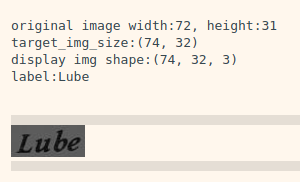  

위 그림은 이전 스텝에서 살펴본 실제 데이터셋 예시입니다. 이 케이스를 예로 들었을 때 위 인자들은 다음과 같이 될 것입니다.

- y_true: 실제 라벨 LUBE. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
- y_pred: 우리가 만들 RCNN 모델의 출력 결과. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
- input_length tensor: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
- label_length tensor: 라벨의 실제 정답 길이 U로서, 이 경우에는 4
---
이제, K.ctc_batch_cost()를 활용하여, image_input을 입력으로, 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현해 봅시다.

In [14]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


# 11-8. Recognition model (5) Train & Inference

이제 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜봅시다.

In [15]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


실제 학습을 위해선 많은 시간이 소요되니 여기서는 예시로 1 Epoch만 돌려보겠습니다. 뒤에서는 20Epoch 이상 학습된 모델의 가중치를 불러와서 진행할게요.😘

EarlyStopping을 이용하면 훈련이 더 빨리 끝날 수도 있어요!
(tf.keras.callbacks.EarlyStopping을 활용해서 한 번 코드를 완성시켜 볼까요?)

In [17]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
# [[YOUR CODE]]
ckp = ModelCheckpoint(
    filepath=checkpoint_path,  # 모델 저장 경로
    monitor='val_loss',        # 모니터링할 지표
    save_best_only=True,       # 가장 낮은 val_loss를 가진 모델만 저장
    save_weights_only=True,    # 가중치만 저장
    verbose=1                  # 저장 시 로그 출력
)

# EarlyStopping: 검증 손실(val_loss)이 개선되지 않으면 조기 종료
earlystop = EarlyStopping(
    monitor='val_loss',       # 모니터링할 지표
    patience=5,               # 개선되지 않는 에포크 수 (5 에포크 동안 개선 없으면 종료)
    restore_best_weights=True, # 가장 성능이 좋은 weight로 복원
    verbose=1                 # 조기 종료 시 로그 출력
)

model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=1,
          validation_data=val_set,
          validation_steps=len(val_set),
          # ModelCheckPoint와 EarlyStopping을 활용하는 경우 바로 아래 callbacks 옵션에 주석을 풀어주세요.
          callbacks=[ckp, earlystop]
)

565/565 [==============================] - 96s 147ms/step - loss: 25.5222 - val_loss: 24.3750

Epoch 00001: val_loss improved from inf to 24.37502, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5


이제 학습된 모델을 테스트셋을 통해 확인해 볼 차례입니다.

In [ ]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

학습된 모델의 성능을 눈으로 확인해봅시다.

Result: 	 SLINKING9999999999999999


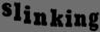

Result: 	 ALEPPO99999999999999999


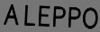

Result: 	 FWANDA999999999999999999


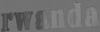

Result: 	 NATHANS99999999999999999


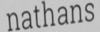

Result: 	 HALLE999999999999999999


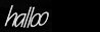

Result: 	 HURLS9999999999999999999


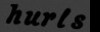

Result: 	 DOWNSIZE9999999999999999


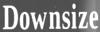

Result: 	 ROBOTIC99999999999999999


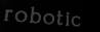

Result: 	 SLOPPY99999999999999999


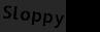

Result: 	 SHERMITE9999999999999999


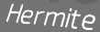

In [19]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)